![BankClientClassification](img/Finance.jpg)

# <center>Проект 4: Классификация клиентов банка</center>  

### Описание проекта  
Предоставлены *реальные данные* о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Успешное выполнение задачи позволит поднять доходы банка и поможет понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.  

### Бизнес-задача  
Определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.  

### Техническая задача для специалиста в Data Science  
Построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

- deposit.

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

import optuna

### Задание 1

In [2]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df = pd.read_csv('data/bank_fin.csv', sep = ';')
print(df.info())
display('Количество пропусков:', df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
None


'Количество пропусков:'

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Пропуски найдены в признаке `balance`.

### Задание 2

In [3]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Скрытые пропуски в признаке `job` обозначены словом `unknown`.

### Задание 3

In [293]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: float(str(x).replace(' ', '').replace('$', '').replace(',', '.')))

# Проверим, что преобразования выполнены корректно
print('Признак `balance` преобразован к типу `float`:', df['balance'].dtype == float)

# Вычислим среднее
print('Среднее значение `balance` =', round(df['balance'].mean(), 3))

Признак `balance` преобразован к типу `float`: True
Среднее значение `balance` = 1529.129


### Задание 4

In [294]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].fillna(df['balance'].median(), inplace=True)

# Вычислим среднее
print('Среднее значение `balance` =', round(df['balance'].mean(), 3))

Среднее значение `balance` = 1526.936


### Задание 5

In [295]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# Выделяем наблюдения с неизвестными значениями
j_ind = df[df['job'] == 'unknown'].index
e_ind = df[df['education'] == 'unknown'].index

#  Заменяем неизвестные значения на моду
df.loc[j_ind, 'job'] = df['job'].mode()[0]
df.loc[e_ind, 'education'] = df['education'].mode()[0]

# Расчитаем среднюю зарплату для клиентов с самыми популярными работой и образованием
mask1 = df['job'] == df['job'].mode()[0]
mask2 = df['education'] == df['education'].mode()[0]
print('Средняя зарплата клиентов с самыми распространенными работой и образованием:',\
      round(df[mask1 & mask2]['balance'].mean(), 3))

Средняя зарплата клиентов с самыми распространенными работой и образованием: 1598.883


### Задание 6

In [296]:
# удалите все выбросы для признака balance - воспользуемся методом Тьюки
# Определим нижний и верхний квартили и вычислим межквартильный размах
quartile_1 = df['balance'].quantile(0.25)
quartile_3 = df['balance'].quantile(0.75)
iqr = quartile_3 - quartile_1

# Вычислим нижнюю и верхнюю границы отрезка
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
print('Нижняя граница по методу Тьюки:', round(lower_bound))
print('Верхняя граница по методу Тьюки:', round(upper_bound))

# Очистим датафрейм от выбросов, используя не строгую верхнюю границу
df_cleaned = df[(df['balance'] > lower_bound) & (df['balance'] <= upper_bound)]
print(f'После очистки осталось {df_cleaned.shape[0]} записей.')

Нижняя граница по методу Тьюки: -2241
Верхняя граница по методу Тьюки: 4063
После очистки осталось 10105 записей.


## Часть 2:  Разведывательный анализ

### Задание 1

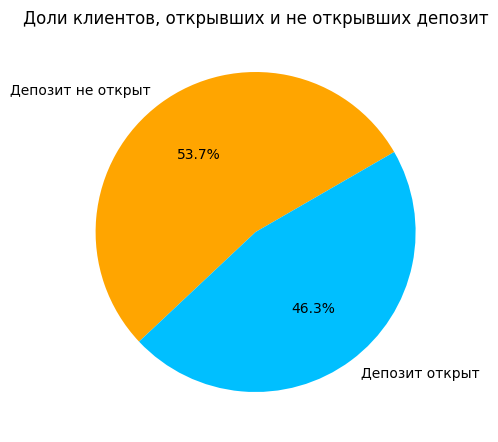

In [380]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

# Построим круговую диаграмму
fig = plt.figure(figsize=(4, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Доли клиентов, открывших и не открывших депозит')
axes.pie(
    #client_type,
    x = df_cleaned['deposit'].value_counts(normalize=True),
    labels = ['Депозит не открыт', 'Депозит открыт'],
    autopct = '%.1f%%',
    colors = ['orange', 'deepskyblue'],
    startangle = 30
);

# print('Количество клиентов, открывших депозит:',df_cleaned['deposit'].value_counts()['yes'])
# > 4681

Можем считать, что наши данные сбалансированы.

### Задания 2 и 3

In [298]:
# рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Проинтерпретируем результаты:  
- **age (возраст)**: медианный возраст всех клиентов - 38 лет, примерно такой же и средний (40); б**о**льшая часть клиентов - в возрасте примерно от 30 до 50 лет; самому молодому клиенту - 18 лет, самому пожилому - 95; интересно будет проверить остальные признаки у молодых и пожилых клиентов, чтобы убедиться, что это не аномалии;  
- **balance (баланс счета)**: заметна разница между средним и медианным размером (почти двукратная), но большинство клиентов имеют на счетах от 95$ до 1227$ (на что указывает большое стандартное отклонение); максимальный баланс 4063$ вполне возможен даже для представителя среднего класса, а вот минимальное отрицательное значение -2049$ стоит проверить: это либо аномалия, либо признак задолженности (использования овердравфта);  
- **day (день последнего контакта с клиентом)**: желательно интерпретировать данный признак вместе с месяцем контакта, однако можно сказать, что большинство контактов осуществлены сотрудниками банка между 8 и 22 числами, то есть на 2-й и 3-й неделе месяца;  
- **duration (продолжительность контакта)**: звонок в среднем длится 6 с небольшим минут, однако поскольку есть звонки, длящиеся больше часа (значение max), как и звонки по 2 секунды (видимо, недозвон), то лучше ориентироваться на медиану, согласно которой разговор с клиентом занимает 4 с небольшим минуты; большинство звонков длятся от 2 до 8 минут;  
- **campaign (количество контактов с клиентом в течение данной маркетинговой кампании)**: как правило, мы видим, что с каждым клиентом контактируют 2 раза (медиана), большинство контактов насчитывает от 1 до 3; но есть сведения о 43 контактах с одним клиентом, что выглядит странно (либо долго не могли дозвониться, звонки сбрасывались, что вряд ли, потому что зачем такая настойчивость, либо это ошибка ввода данных) - стоит эту аномалию проверить;  
- **pdays (количество пропущенных дней между кампаниями)**: сложно понять, что означает "пропущенные дни", возможно это просто дни между контактами в рамках различных кампаний; из-за огромного максимального значения (854 дня, что равно 2 годам и 4 месяцам) будем оперировать медианой, ее отрицательное значение, вероятно указывает на то, что с данным клиентом впервые контактировали в текущей кампании (то есть он не был клиентом в предыдущую кампанию, либо не участвовал в ней) - этот тезис подтверждает следующий признак; а отрезок в 854 дня, скорее всего, является аномалией, потому что вряд ли кампании проводятся так редко;  
- **(количество контактов до текущей кампании)**: медианное значение, равное нулю, указывает на то, что до текущий кампании с клиентами не контактировали, что подтверждает значение `-1` у признака `pdays`, рассмотренного выше; 58 контактов с одним клиентом стоит проверить: действительно клиент так долго является клиентом банка, что за это время с ним успели связаться столько раз; либо это ошибка ввода.  

Построим диаграммы, иллюстрирующие рассмотренные признаки.  

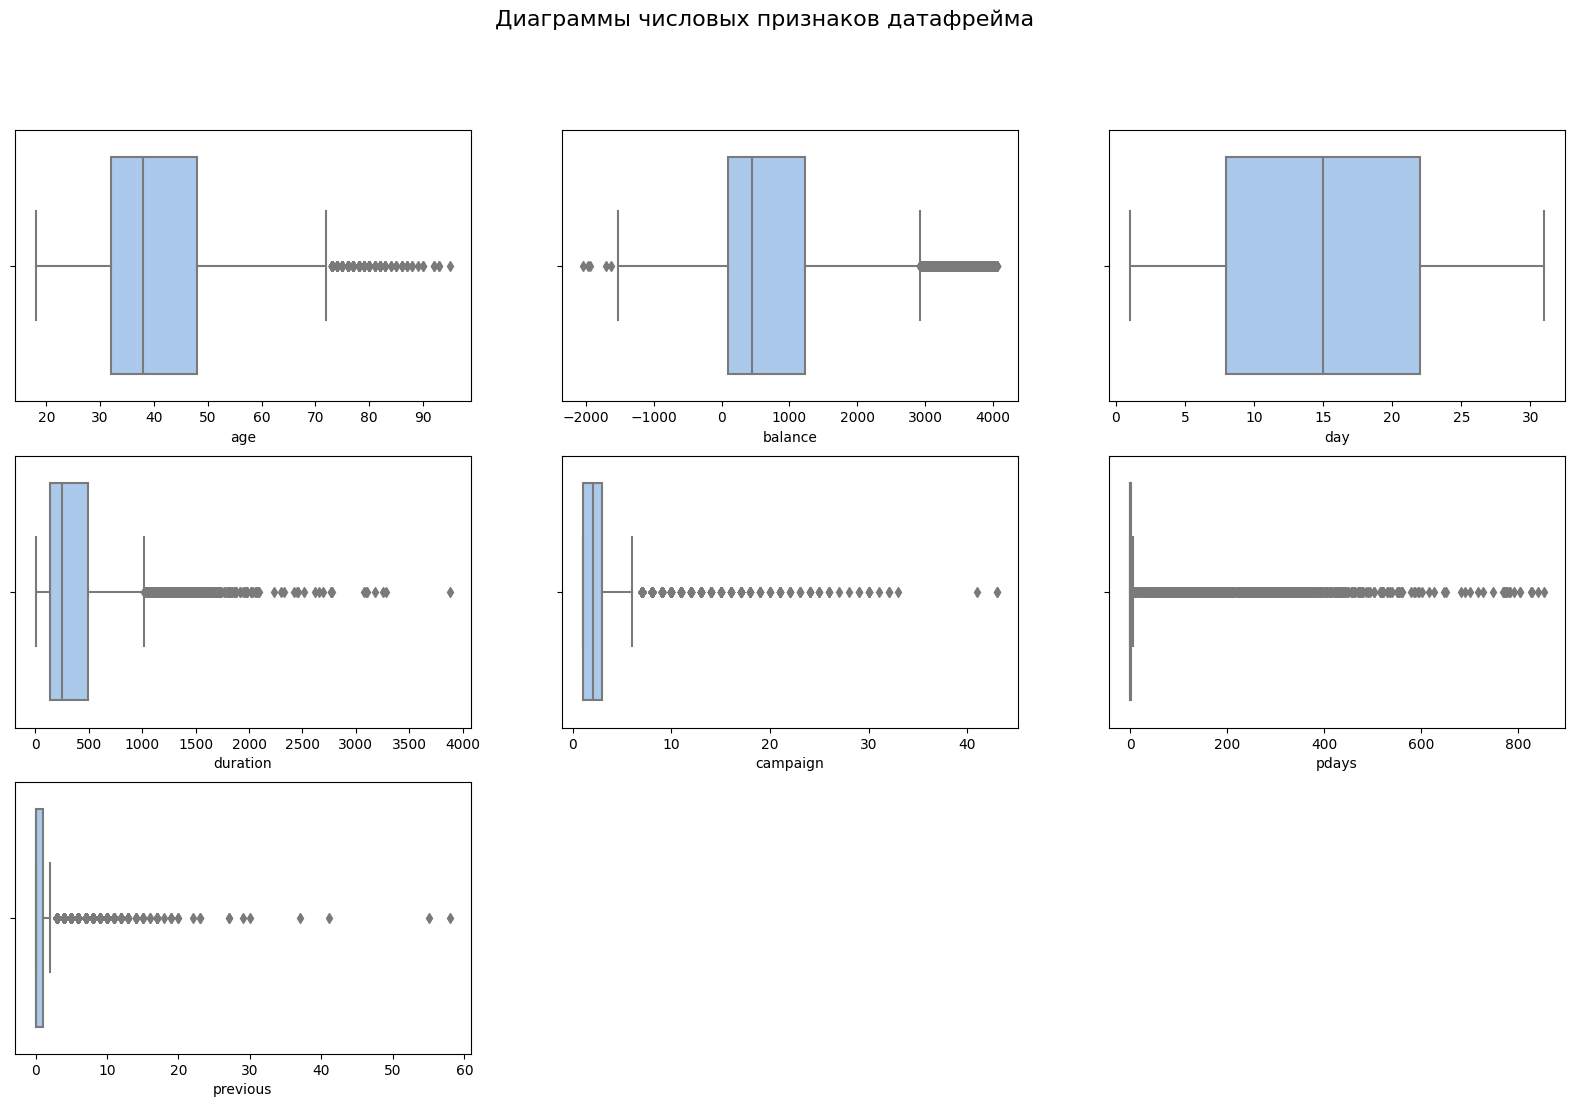

In [299]:
# Построим коробчатые диаграммы числовых признаков
# Сохраним в переменную названия столбцов числовых признаков
num_cols = df_cleaned.describe().columns

# Зададим количество строк и столбцов для графиков
ncols = 3
nrows = 3

# Построим графики
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4*nrows))
for i, feat in enumerate(num_cols):
    sns.boxplot(data=df_cleaned, x=feat, ax=axes[divmod(i,ncols)], palette='pastel');
fig.delaxes(axes[2][1]);
fig.delaxes(axes[2][2]);
fig.suptitle('Диаграммы числовых признаков датафрейма', fontsize=16);

Исходя из увиденного на графиках, нельзя однозначно утверждать, что значения, выходящие за 1 и 3 квартили являются однозначными аномалиями. Кроме этого, при выводе на экран записей о клиентах с предположительно аномальными значениями рассмотренных признаков, мы получаем значительный массив правдоподобных данных, который при его удалении лишит нас большой части наблюдений, что может негативно сказаться на качестве предсказания модели. Поэтому принимаем решение не удалять аномалии и не определять их дополнительными методами (например с помощью метода Тьюки, трех сигм и др.).

### Задания 4 и 5

In [300]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df_cleaned.describe(include='object')


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Проинтерпретируем результаты:  
- **job (cфера занятости)**: после замены пропусков в виде неизвестной сферы, мы получили 11 различных сфер, самой часто встречающейся из которых является управление "management", впрочем частота появления (2315) указывает на то, что и другие сферы представлены значительным числом клиентов (это можно увидеть на гистограмме: второй по частоте является сфера физического труда "blue-collar", а третьей - техники и механики "technician");  
- **marital (семейное положение)** представлено 3-мя категориями: больше половины клиентов состоят в браке; две другие: неженатые и разведенные;  
- **education (уровень образования)**: больше половины клиентом имеют среднее образование, оставшиеся две категории - это высшее и начальное школьное;  
- **default (имеется ли просроченный кредит)**: почти у всех клиентов нет просроченного кредита;  
- **housing (имеется ли кредит на жильё)**: клиенты банка примерно поровну распределились на тех, у кого есть кредит на жилье, и тех, у кого его нет, но вторая группа слегка преобладает;  
- **loan (имеется ли кредит на личные нужды)**: у большей частей клиентов нет потребительских кредитов;  
- **contact (тип контакта с клиентом)**: наиболее частый способ связи - это звонок на мобильный телефон клиента; две оставшиеся категории представлены стацинарным телефоном и неизвестным способом связи (возможно личный контакт в офисе или ошибка внесения данных);  
- **month (месяц, в котором был последний контакт)**: контакты с клиентами осуществлялись на протяжении всех 12 месяцев в году, но с небольшим преобладанием - в мае: можно предположить, что банк чаще предлагал клиентам открыть депозит с целью сохранения денег на период летних отпусков, когда дома пустуют и подвергаются повышенному риску ограбления;  
- **poutcome (результат прошлой маркетинговой кампании)** представлен 4-мя категориями, самая популярная из которых - "неизвестно", три другие: "неудача", "успех" и "прочее"; пока не понятно, какую ценность может принести признак с преимущественным значением "неизвестно", возможно, от него придется избавиться на этапе отбора признаков;    
- **deposit (открыт ли депозит)**: целевой признак, состоящий из двух значений ("да" и "нет"), примерно поровну распределенных, но с небольшим перевесом в сторону отказавшихся от депозита.  

Построим диаграммы, иллюстрирующие рассмотренные признаки.  

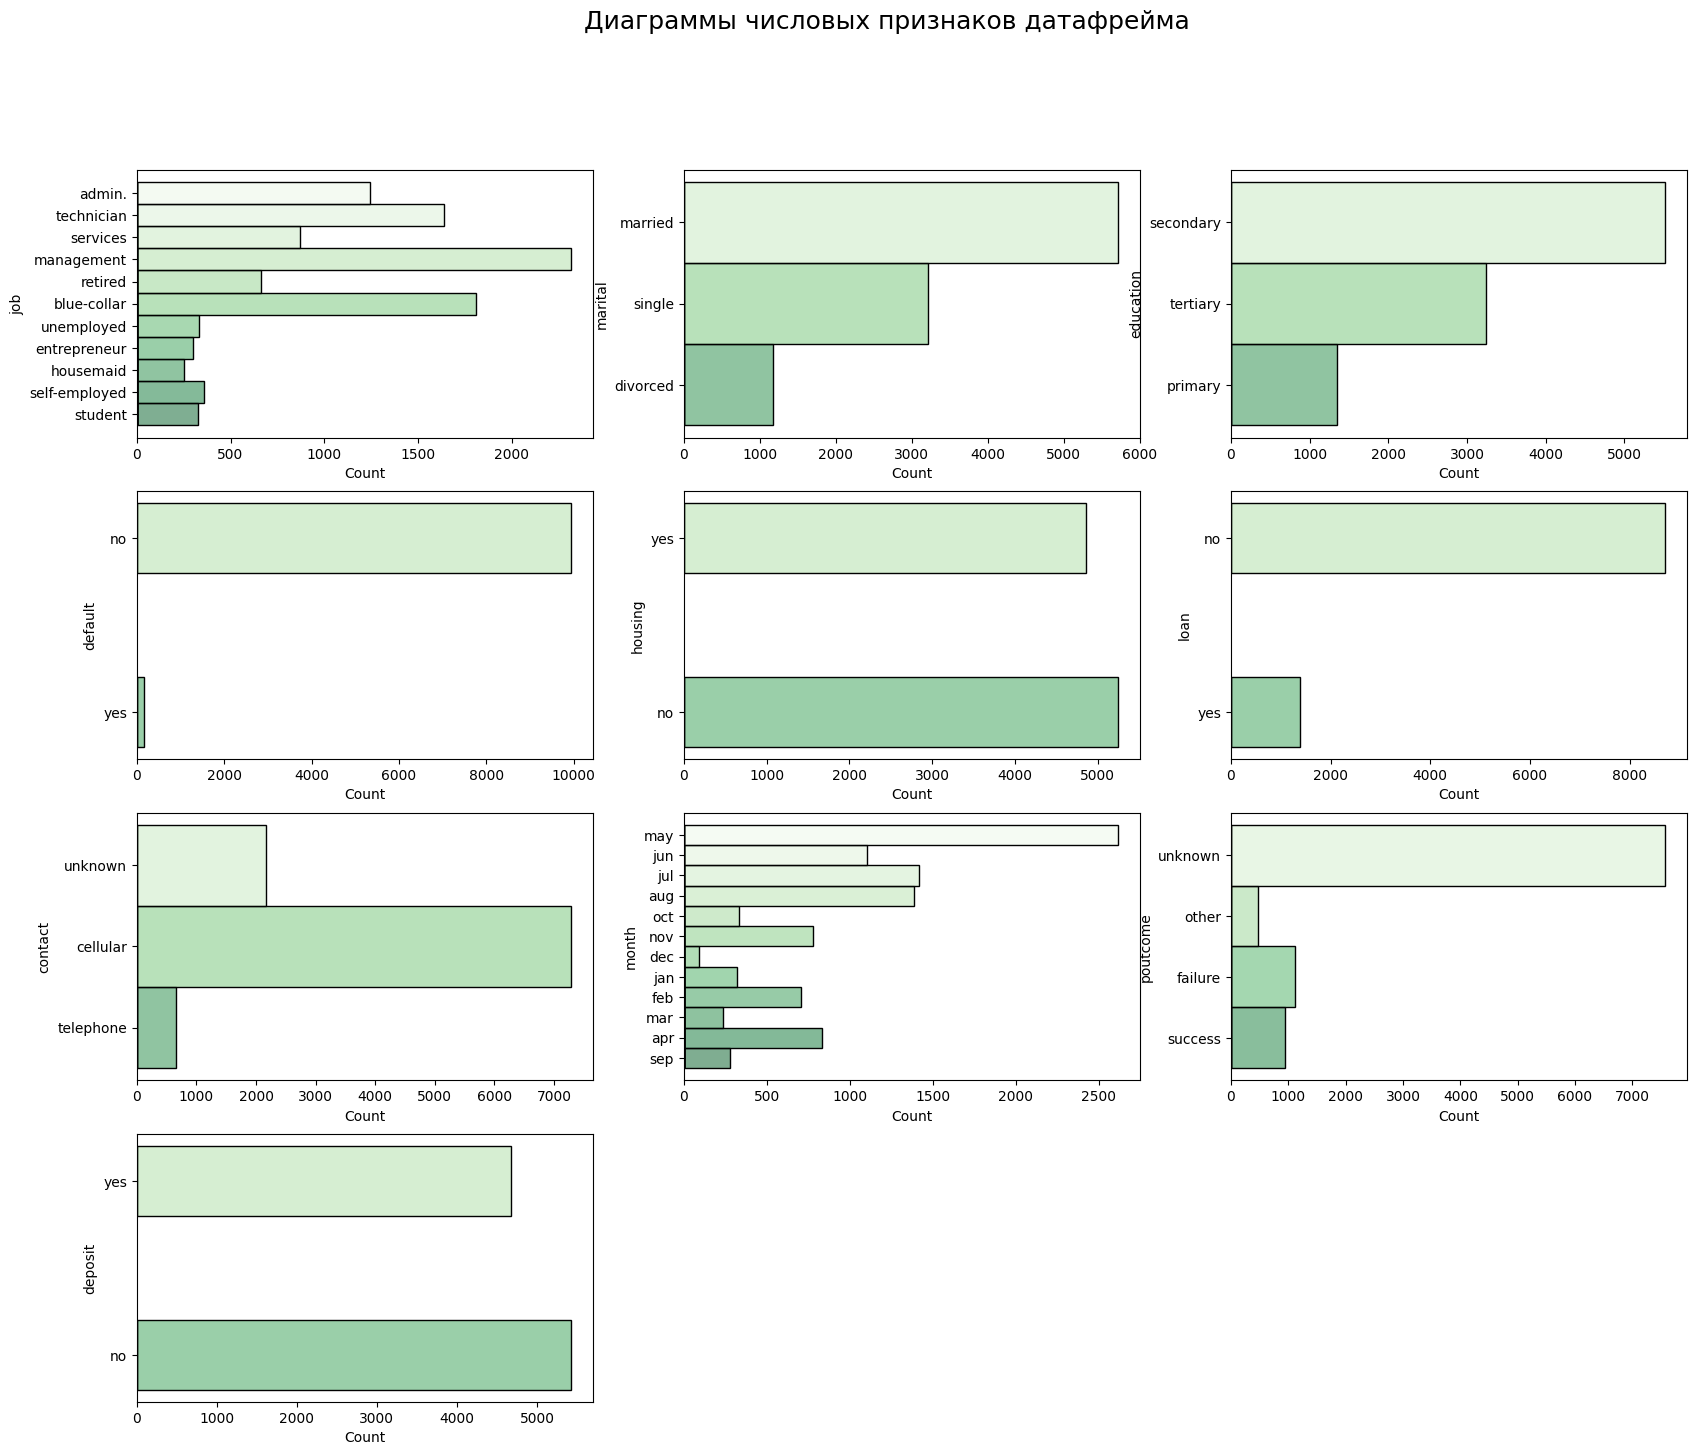

In [301]:
# постройте визуализации, иллюстрирующие результаты
# Построим гистограммы категориальных признаков
# Сохраним в переменную названия столбцов категориальных  признаков
cat_cols = df_cleaned.describe(include='object').columns

# Зададим количество строк и столбцов для графиков
ncols = 3
nrows = 4

# Построим графики
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4*nrows))
for i, feat in enumerate(cat_cols):
    sns.histplot(
        data = df_cleaned,
        y = feat,
        hue = df_cleaned[feat].values,
        shrink = (0.4 if df_cleaned[feat].nunique() < 3 else 1),
        palette='Greens',
        legend = False,
        ax = axes[divmod(i,ncols)]
    );
fig.delaxes(axes[3][1]);
fig.delaxes(axes[3][2]);
fig.suptitle('Диаграммы числовых признаков датафрейма', fontsize=18);

Из графиков видно, что малочисленными являются такие **сферы занятости**, как домохозяйки, предприниматели, студенты, самозанятые и безработные. Подавляющее большинство **контактов** с клиентами осуществлялось посредством мобильной связи, поэтому при сохранении данного признака значение "unknown" можно будет заменить на "cellular".  
Месяц май с большим отрывов лидирует среди всех **месяцев по количеству контактов**, за ним следуют все три летних месяца. Кроме безопасности хранения средств, депозиты в эти месяцы могли предлагать открыть с целью накопить определенную сумму к Новому году - времени подарков и больших покупок. В декабре же с клиентами контактировали менее всего в рамках данной маркетинговой кампании.  
Гистограмма **результатов прошлой кампании** показывает, что почти все ее итоги неизвестны. С таким разпределением данный признак не несет никакой ценности и является первым кандидатом на выбывание.

### Задание 6

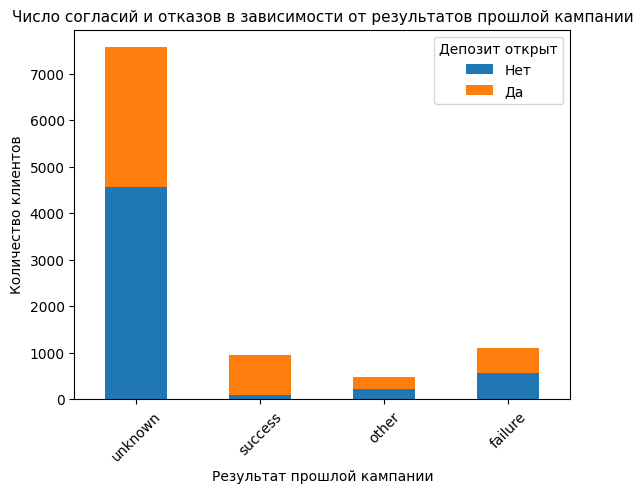

In [302]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
outcomes = df_cleaned.groupby("poutcome")['deposit'].value_counts().unstack().sort_values(by='poutcome', ascending=False)
outcomes.plot(
    kind='bar',
    stacked='True',
    xlabel = 'Результат прошлой кампании',
    ylabel = 'Количество клиентов'
);

plt.legend(title='Депозит открыт', labels=['Нет', 'Да']);
plt.tick_params(axis='x', rotation=45);
plt.title('Число согласий и отказов в зависимости от результатов прошлой кампании', fontsize=11);

Как видно на диаграмме, количество согласий на открытие депозита в рамках текущей кампании превалирует среди тех клиентов, результат участия которых в предыдущей кампании помечен категорией "успех" ("success"). Для категории "other" количество согласий также выше количества отказов, но превалированием это назвать нельзя.

### Задание 7

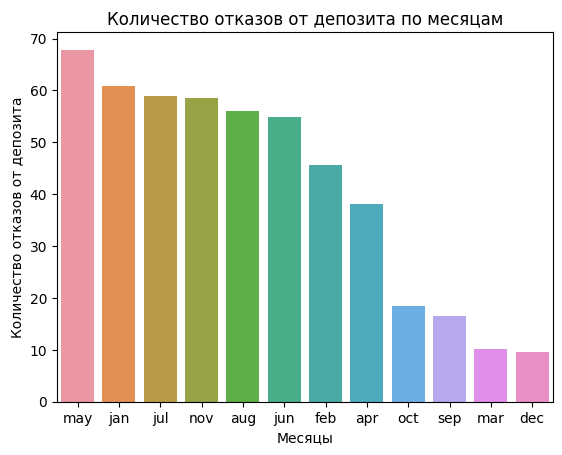

In [303]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
no_month = df_cleaned.groupby('month')['deposit'].value_counts().unstack().sort_values(by='no', ascending=False)
no_month['fail_ratio'] = round(no_month['no'] / (no_month['no']+no_month['yes']) * 100, 2)
no_month.sort_values(by='fail_ratio', ascending=False, inplace=True)

barplot = sns.barplot(
    data = no_month,
    y = 'fail_ratio',
    x = no_month.index
);

barplot.set_title('Количество отказов от депозита по месяцам');
barplot.set_xlabel('Месяцы');
barplot.set_ylabel('Количество отказов от депозита');

Из графика следует, что наибольший процент отказов приходится на май. Это вполне объяснимо: чем больше контактов с клиентами - тем больше отказов, ведь как мы видели на предыдущих диаграммах, число клиентов, отказавшихся открыть депозит, несколько превышает число согласившихся. Впрочем, стоит отметить, что и количество согласий в мае наибольшее за весь год. Ну а самым успешным, с точки зрения согласий, стал месяц декабрь.

### Задание 8

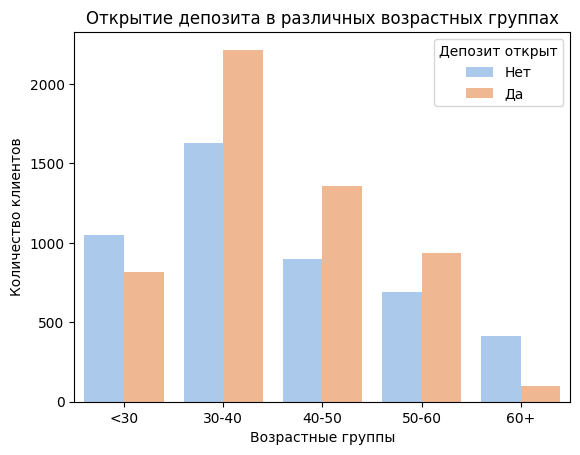

In [304]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_cleaned['age_group'] = pd.cut(df_cleaned['age'],
                                 [0,30,40,50,60,9999],
                                 labels = ['<30','30-40','40-50','50-60','60+'],
                                 right = True)

# Построим диаграмму для наглядности
countplot = sns.countplot(
    data = df_cleaned,
    x = 'age_group',
    hue = 'deposit',
    palette = 'pastel'
);

countplot.set_title('Открытие депозита в различных возрастных группах');
countplot.set_xlabel('Возрастные группы');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт', labels=['Нет', 'Да']);

Итак, более склонны открывать депозиты клиенты моложе 30 и старше 60 лет: в этих группах количество согласий превышает количество отказов.

### Задания 9 и 10

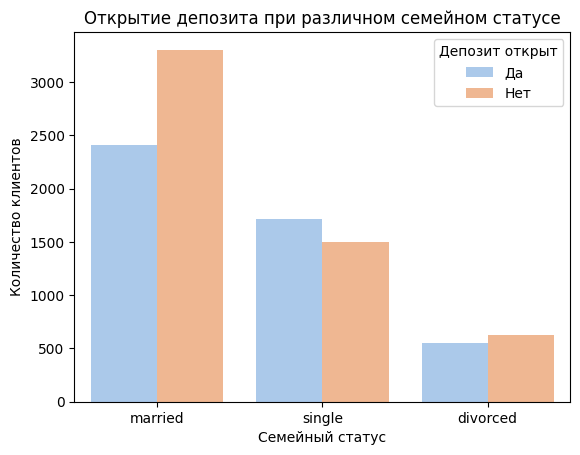

In [305]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
countplot = sns.countplot(
    data = df_cleaned,
    x = 'marital',
    hue = 'deposit',
    palette = 'pastel'
);

countplot.set_title('Открытие депозита при различном семейном статусе');
countplot.set_xlabel('Семейный статус');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт', labels=['Да', 'Нет']);

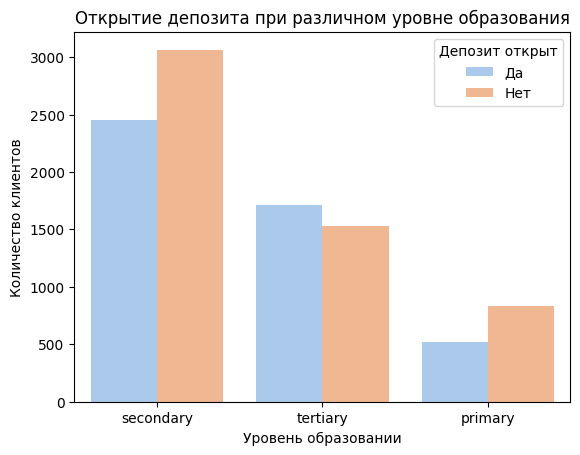

In [306]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
countplot = sns.countplot(
    data = df_cleaned,
    x = 'education',
    hue = 'deposit',
    palette = 'pastel'
);

countplot.set_title('Открытие депозита при различном уровне образования');
countplot.set_xlabel('Уровень образовании');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт', labels=['Да', 'Нет']);

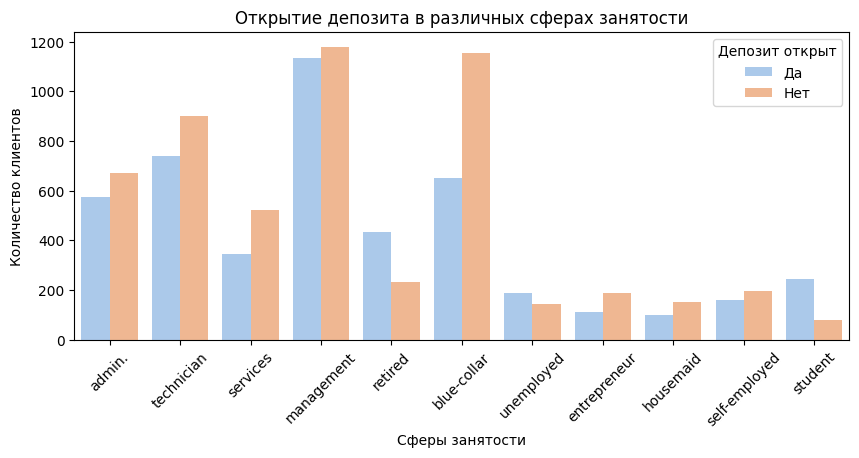

In [307]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(10,4))
countplot = sns.countplot(
    data = df_cleaned,
    x = 'job',
    hue = 'deposit',
    palette = 'pastel'
);

countplot.set_title('Открытие депозита в различных сферах занятости');
countplot.set_xlabel('Сферы занятости');
countplot.set_ylabel('Количество клиентов');
countplot.legend(title='Депозит открыт', labels=['Да', 'Нет']);
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45);


По признаку **семейного статуса** чаще открывают депозит, чем отказываются это сделать, неженатые/незамужние клиенты. Вероятно, их соотношение их доходов и расходов позволяет отложить часть денег. А вот намного чаще отказываются семейные клиенты, видимо, по причине высоких семейных расходов. Примерно такое же объяснение можно подобрать и для разведенных клиентов: их расходы, требующие наличных средств, могут быть связаны с выплатой алиментов или погашением долгосрочных кредитов, взятых в браке, и проч.  

По признаку **образования** охотнее открывают депозиты люди с высшим образованием; чаще отказываются - со средним и начальным. Скорее всего, высшее образование позволяет его носителям получать более высокое жалование и откладывать часть денег.  

Наконец, по признаку **занятости** охотнее всего дают согласие вышедшие на пенсию, студенты и безработные. Резко негативное отношение наблюдается от представителей "синих воротничков" - рабочих, занимающихся физическим трудом. По всей видимости, жалованья от такой низкооплачиваемой работы едва хватает на покрытие ежедневных расходов, поэтому лишних денег для депозита просто не находится. Можно предположить, что представители этой сферы занятости, как правило, имеют начальное или среднее образование и состоят в браке (отчасти с целью увеличения совокупного дохода), что, как следует из двух предыдущих диаграмм, является предпосылкой к отказу от депозита.  

### Задание 11

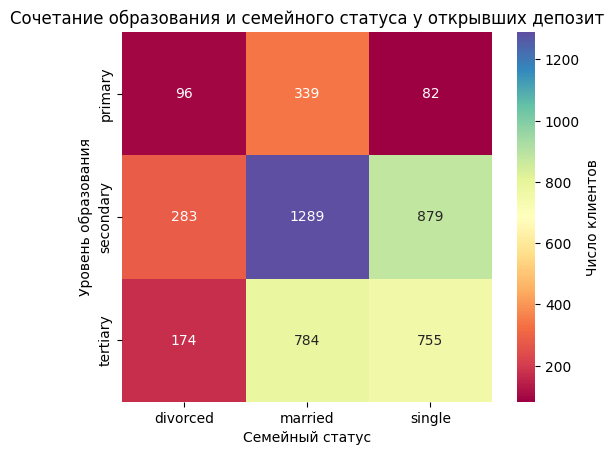

In [308]:
# постройте сводную таблицу, чтобы определить, люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

# Сперва преобразуем признак  депозита в двоичный вид
df_cleaned['deposit_num'] = df_cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Построим сводную таблицу, используя бинарный признак депозита
edu_mar = pd.pivot_table(
    data = df_cleaned,
    index = 'education',
    columns = 'marital',
    values = 'deposit_num',
    aggfunc = 'sum'
)

# Избавимся от временного бинарного признака (хотя он нам потребуется в дальнейшем)
df_cleaned.drop('deposit_num', axis=1, inplace=True)

# Построим тепловую карту для наглядности
heatmap = sns.heatmap(
    data = edu_mar,
    cmap='Spectral',
    cbar_kws={'label':'Число клиентов'},
    annot = True,
    fmt = '.0f',
    square = True
)
heatmap.set_title('Сочетание образования и семейного статуса у открывших депозит');
heatmap.set_xlabel('Семейный статус');
heatmap.set_ylabel('Уровень образования');

Самой многочисленной группой клиентов, согласившихся открыть депозит, являются женатые/замужние клиенты со средним образованием. Несмотря на наши предыдущие выводы о том, что наилучими потенциальными клиентами являются холостые с высшим образованием, в виду многочисленности клиентов в браке и широкой распространенности среднего образования, наибольшее количество открывших депозит, оказалось именно в этой категории.  

Правая нижняя часть тепловой карты указывает на то, что банку лучше сосредотачивать свои усилия на женатых/замужних или одиноких клиентах (но не разведенных) с образованием не ниже среднего.  

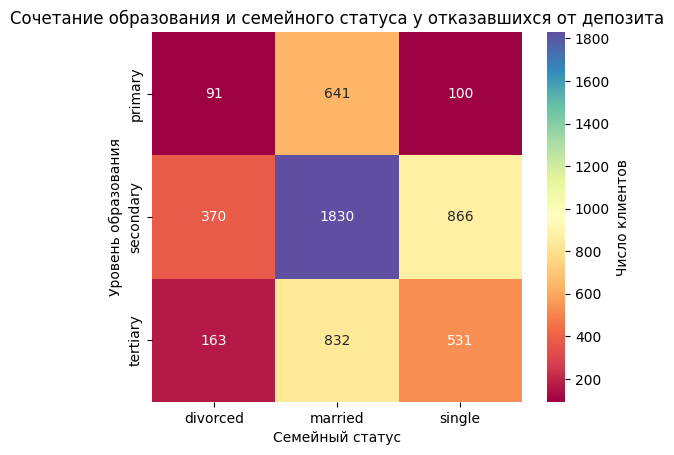

In [309]:
# Построим схожую тепловую карту, но для клиентов, которые отказались от депозита
# Для этого обратим бинарное кодирование признака deposit
df_cleaned['deposit_num'] = df_cleaned['deposit'].apply(lambda x: 1 if x == 'no' else 0)

# Построим сводную таблицу, используя бинарный признак депозита
edu_mar_2 = pd.pivot_table(
    data = df_cleaned,
    index = 'education',
    columns = 'marital',
    values = 'deposit_num',
    aggfunc = 'sum'
)

# Избавимся от временного бинарного признака (хотя он нам потребуется в дальнейшем)
df_cleaned.drop('deposit_num', axis=1, inplace=True)

# Построим тепловую карту для наглядности
heatmap = sns.heatmap(
    data = edu_mar_2,
    cmap = 'Spectral',
    cbar_kws = {'label':'Число клиентов'},
    annot = True,
    fmt = '.0f',
    square = True
)
heatmap.set_title('Сочетание образования и семейного статуса у отказавшихся от депозита');
heatmap.set_xlabel('Семейный статус');
heatmap.set_ylabel('Уровень образования');

Как видно, те же самые группы чаще всего и отказываются от открытия депозита. Возможно, это указывает на то, что стоит обратить внимание и на другие признаки, которые могут играть решающую роль.  
Однако с уверенностью можно заявить, что среди всех групп одинокие клиенты с высшим образованием чаще соглашаются на открытие депозита (755 клиентов), чем отказываются от него (531).  

## Часть 3: Преобразование данных

### Задание 1

In [310]:
# преобразуйте уровни образования
le = LabelEncoder()
df_cleaned['education'] = le.fit_transform(df_cleaned['education'])

Сохраним коды уровней образования:  
- 0 - primary  
- 1 - secondary  
- 2 - tertiary  

### Задания 2 и 3

In [311]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_cleaned['age_group']  = le.fit_transform(df_cleaned['age_group'])
df_cleaned['deposit'] = le.fit_transform(df_cleaned['deposit'])
df_cleaned['default'] = le.fit_transform(df_cleaned['default'])
df_cleaned['housing'] = le.fit_transform(df_cleaned['housing'])
df_cleaned['loan'] = le.fit_transform(df_cleaned['loan'])

Сохраним коды возрастных групп:  
- 0 - 30-40  
- 1 - 40-50  
- 2 - 50-60  
- 3 - 60+  
- 4 - <30  

Сохраним коды решений по признакам: `deposit, default, housing, loan`  
- 0 - no  
- 1 - yes  

### Задание 4

In [312]:
# создайте дамми-переменные
df_cleaned = pd.get_dummies(df_cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

# Проверим размерность, должно получиться 46 столбцов
print('Размерность датафрейма:', df_cleaned.shape)

Размерность датафрейма: (10105, 46)


### Задания 5 и 6

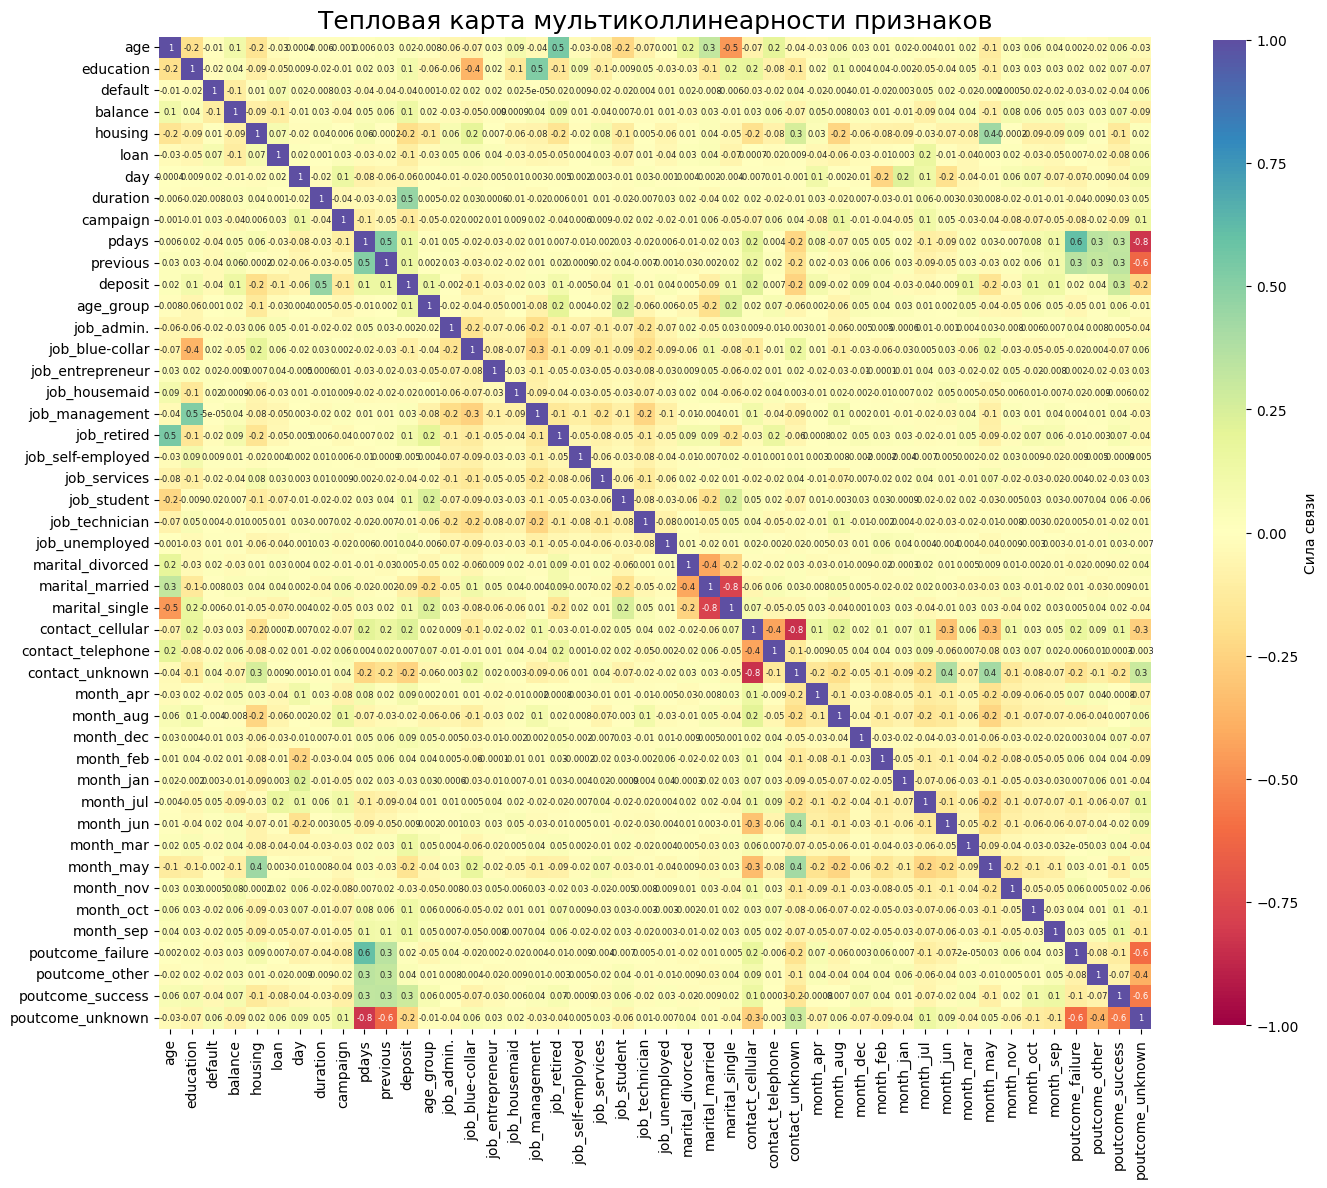

In [313]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(16, 16))
heatmap = sns.heatmap(
    data = df_cleaned.corr(),
    cmap = 'Spectral',
    cbar_kws = {'label':'Сила связи', 'shrink': 0.8, 'aspect': 30},
    vmin = -1.0,
    annot = True,
    fmt = '.1g',
    annot_kws = {'size': 6},
    square = True
)
heatmap.set_title('Тепловая карта мультиколлинеарности признаков', fontsize=18);

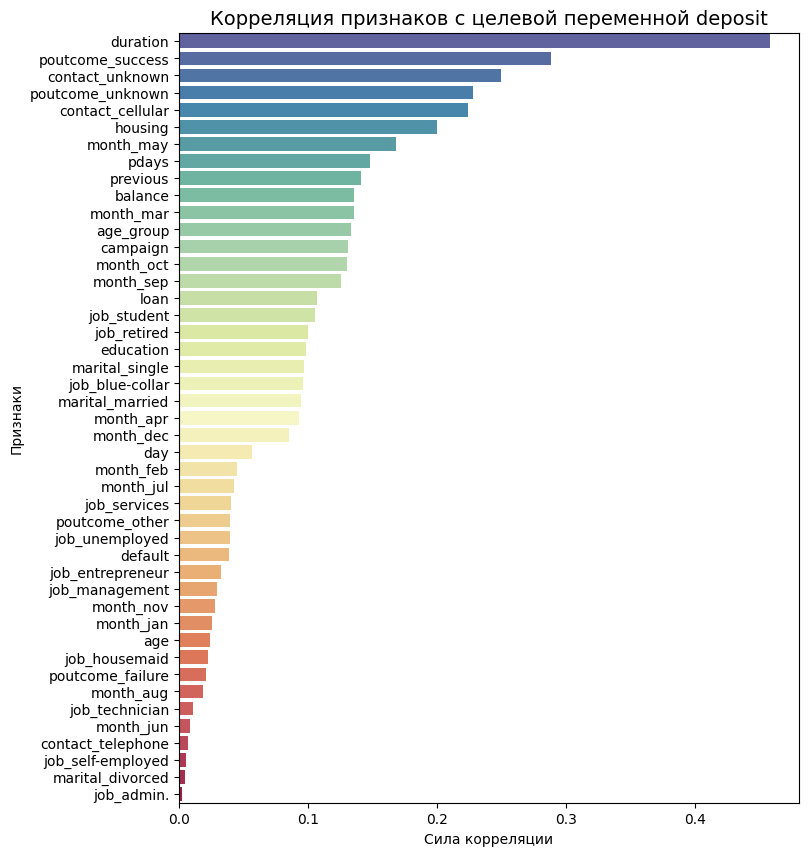

In [356]:
# Сохраним в переменную значения корреляции признаков с целевым deposit
dep_cor = df_cleaned.corr()['deposit']
dep_cor = dep_cor.drop('deposit').abs().sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую эту корреляцию
fig = plt.figure(figsize=(8, 10))
barplot = sns.barplot(
    data = dep_cor.to_frame().reset_index(),
    x = 'deposit',
    y = 'index',
    orient = 'h',
    palette = 'Spectral_r'
);

barplot.set_title('Корреляция признаков с целевой переменной deposit', fontsize = 14);
barplot.set_xlabel('Сила корреляции');
barplot.set_ylabel('Признаки');

Согласно тепловой карте, отсутствуют сильно скоррелированные признаки (сила связи которых превышала бы 0.9).  
А на диаграмме корреляции мы видим, что наибольшим значением на принятие решения об открытии депозита обладает длительность разговора с клиентом, затем успех контактов в предыдущей кампании. А вот семейное положение и образование не так сильно влияют на результат.

### Задания 7 и 8

In [27]:
# Создадим набор предикторов и вектор ответов
X = df_cleaned.drop(['deposit'], axis=1)
y = df_cleaned['deposit']

# Разобьем выборку с сохранением соотношения целевого признака
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [28]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки:', X_test.shape[0])
print('Cреднее значение целевой переменной на тестовой выборке:', round(y_test.mean(),2))

Размер тестовой выборки: 3335
Cреднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [29]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selected_feat = list(selector.get_feature_names_out())
display('Отобранные признаки:', selected_feat)

X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

'Отобранные признаки:'

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [30]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [95]:
# обучите логистическую регрессию и рассчитайте метрики качества
RANDOM_SEED = 42

# Создаем модель
lr = linear_model.LogisticRegression(
    solver = 'sag',
    max_iter = 1000,
    random_state = RANDOM_SEED
)

# Обучаем модель
lr.fit(X_train_scaled, y_train)

# Делаем предсказание и выводим метрики качества
y_train_predict = lr.predict(X_train_scaled)
y_test_predict = lr.predict(X_test_scaled)
print('Метрика accuracy на тренировочной выборке:',
        round(metrics.accuracy_score(y_train, y_train_predict), 2))
print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_predict), 2))

Метрика accuracy на тренировочной выборке: 0.82
Метрика accuracy на тестовой выборке: 0.81


Мы получили хороший результат с помщью логистической регрессии. Посмотрим, что нам даст модель решающего дерева.

### Задания 2,3,4

In [32]:
# обучите решающие деревья, настройте максимальную глубину
# Создаем модель
dt = tree.DecisionTreeClassifier(
    criterion = 'entropy',
    random_state = RANDOM_SEED
)

# Обучаем модель
dt.fit(X_train_scaled, y_train)

# Делаем предсказание и выводим метрики качества
y_train_predict = dt.predict(X_train_scaled)
y_test_predict = dt.predict(X_test_scaled)
print('Метрика accuracy на тренировочной выборке:',
        round(metrics.accuracy_score(y_train, y_train_predict), 2))
print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_predict), 2))

Метрика accuracy на тренировочной выборке: 1.0
Метрика accuracy на тестовой выборке: 0.75


Метрика ухудшилась на тестовой выборке, и при этом мы сталкнулись с переобучением модели! Стоит попробовать другие значения параметров, например, максимальную глубину дерева. Для подбора заключим все операции в функцию ниже:

In [33]:
# Напишем функцию, которая будет обучать модель и выводить метрику
def find_max_depth(m_d: int = 5,
                   X_train_scaled: pd.DataFrame = X_train_scaled,
                   X_test_scaled: pd.DataFrame = X_test_scaled,
                   y_train: pd.Series = y_train,
                   y_test: pd.Series = y_test) -> None:
    """Функция обучает модель решающего дерева, делает предсказание
    и выводит значения метрик на тестовой выборке.

    Args:
        m_d (int, optional): максимальная глубина дерева. По умолчанию = 5.
        X_train_scaled (pd.DataFrame, optional): обучающая выборка. По умолчанию = X_train_scaled.
        X_test_scaled (pd.DataFrame, optional): тестовая выборка. По умолчанию = X_test_scaled.
        y_train (pd.Series, optional): ответы обучающей выборки. По умолчанию = y_train.
        y_test (pd.Series, optional): ответы тестовой выборки. По умолчанию = y_test.
    """

    # Создаем модель
    dt = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        max_depth = m_d,
        random_state = RANDOM_SEED
    ) 

    # Обучаем модель
    dt.fit(X_train_scaled, y_train)

    # Делаем предсказание и выводим метрики качества
    y_train_predict = dt.predict(X_train_scaled)
    y_test_predict = dt.predict(X_test_scaled)
    print(f'Метрика accuracy на тренировочной выборке при глубине {m_d}:',
            round(metrics.accuracy_score(y_train, y_train_predict), 2))
    print(f'Метрика accuracy на тестовой выборке при глубине {m_d}:',
            round(metrics.accuracy_score(y_test, y_test_predict), 2), '\n')

# Запустим написанную функцию для подбора глубины дерева
for i in range(5, 8):
    find_max_depth(m_d=i)

Метрика accuracy на тренировочной выборке при глубине 5: 0.8
Метрика accuracy на тестовой выборке при глубине 5: 0.79 

Метрика accuracy на тренировочной выборке при глубине 6: 0.82
Метрика accuracy на тестовой выборке при глубине 6: 0.81 

Метрика accuracy на тренировочной выборке при глубине 7: 0.84
Метрика accuracy на тестовой выборке при глубине 7: 0.81 



Видно, что при глубинах 6 и 7 значение метрики на тестовой выборке сохраняется равным 0.81, а на тренировочной увеличивается. Это свидетельствует о том, что модель начинает переобучаться. Таким образом, будем считать наилучшим значением глубины дерева 6.  

### Задание 5

In [96]:
# подберите оптимальные параметры с помощью gridsearch

# Создаем сетку перебираемых параметров
param_grid = {
    'min_samples_split': [2, 5, 7, 10], # мин. кол-во наблюдений для деления узла дерева
    'max_depth':[3, 5, 6, 7] # макс. глубина дерева
}

# Создаем модель GridSearch
grid_search = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        random_state = RANDOM_SEED
    ), 
    param_grid = param_grid,
    cv = 5,
    scoring = ('f1'),
    return_train_score = True
)  

# Обучим модель
%time grid_search.fit(X_train_scaled, y_train)
print('Значение accuracy модели GridSearchCV на тестовой выборке:',
      round(grid_search.score(X_test_scaled, y_test), 2))

# Сделаем предсказания и выведем метрики качества
y_train_predict = grid_search.predict(X_train_scaled)
y_test_predict = grid_search.predict(X_test_scaled)
print('\nМетрика accuracy на тренировочной выборке:',
    round(metrics.accuracy_score(y_train, y_train_predict), 2))
print('Метрика accuracy на тестовой выборке:',
    round(metrics.accuracy_score(y_test, y_test_predict), 2),)


print('Метрика f1_score на тестовом наборе:', round(metrics.f1_score(y_test, y_test_predict), 2))
print('\nНаилучшие значения гиперпараметров:', grid_search.best_params_)


CPU times: user 2.18 s, sys: 71 ms, total: 2.25 s
Wall time: 3.47 s
Значение accuracy модели GridSearchCV на тестовой выборке: 0.8

Метрика accuracy на тренировочной выборке: 0.84
Метрика accuracy на тестовой выборке: 0.81
Метрика f1_score на тестовом наборе: 0.8

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


Нам удалось достичь столь же высоких значений метрик, но в этот раз подбор наилучших параметров выполнила за нас модель GridSearchCV.  
Наилучшей оказалось глубина в 7 деревьев при минимальном числе наблюдейний для деления узла = 7.  

## Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [97]:
# обучите на ваших данных случайный лес
# Создаем модель случайного леса
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = RANDOM_SEED
)

# Обучаем модель
%time rf.fit(X_train_scaled, y_train)

# Делаем предсказание и выводим метрики качества
y_test_predict = rf.predict(X_test_scaled)
print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_predict), 2))
print('Метрика f1_score на тестовой выборке:',
        round(metrics.f1_score(y_test, y_test_predict), 2))

# print('\nМетрики в целом:\n', metrics.classification_report(y_test, y_test_predict))

CPU times: user 736 ms, sys: 25.2 ms, total: 761 ms
Wall time: 1.14 s
Метрика accuracy на тестовой выборке: 0.83
Метрика f1_score на тестовой выборке: 0.82


Модель случайного леса позволила нам улучшить значение метрики на тестовой выборке на 0.02 по сравнению с деревом решений, что подтверждает лучшую предсказательную способность ансамблевых методов.

### Задания 2 и 3

In [98]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# Создаем модель градиентного бустинга
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05, # темп обучения
    n_estimators = 300, # число деревьев
    min_samples_leaf = 5, # минимальное число листьев на дереве
    max_depth = 5, # максимальная глубина дерева
    random_state = RANDOM_SEED # генератор случайных чисел
)

# Обучаем модель
%time gb.fit(X_train_scaled, y_train)

# Делаем предсказание и выводим метрики качества
y_test_predict = gb.predict(X_test_scaled)
print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_predict), 2))
print('Метрика f1_score на тестовой выборке:',
        round(metrics.f1_score(y_test, y_test_predict), 2))

# print('\nМетрики в целом:\n', metrics.classification_report(y_test, y_test_predict))

CPU times: user 5.02 s, sys: 68.3 ms, total: 5.09 s
Wall time: 6.94 s
Метрика accuracy на тестовой выборке: 0.83
Метрика f1_score на тестовой выборке: 0.82


При сравнении двух методов (случайного леса и градиентного бустинга) видим, что метрики качества абсолютно идентичны. Таким образом, для решения данной задачи оба метода подходят с той лишь разницей, что метод градиентного бустинга затрачивает почти в 7 раз больше времени (впрочем, на более сильной машине это может быть незаметно).  

### Задание 4

In [99]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# Создаем список моделей в виде кортежей, сохраняем использованные параметры
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion = 'entropy',
        min_samples_split = 7,
        max_depth = 7,
        random_state = RANDOM_SEED)
    ),
    ('lr', linear_model.LogisticRegression(
        solver = 'sag',
        max_iter = 1000,
        random_state = RANDOM_SEED)
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = RANDOM_SEED)
    )
]

# Создаем объект класса стекинг
st_cl = ensemble.StackingClassifier(
    estimators = estimators,
    final_estimator = linear_model.LogisticRegression(
        solver = 'sag',
        max_iter = 1000,
        random_state = RANDOM_SEED)
)

# Обучаем модель
%time st_cl.fit(X_train_scaled, y_train)

# Делаем предсказание и выводим метрики качества
y_test_predict = st_cl.predict(X_test_scaled)
print('Метрика precision на тестовой выборке:',
        round(metrics.precision_score(y_test, y_test_predict), 2))
print('\nМетрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_predict), 2))
print('Метрика f1_score на тестовой выборке:',
        round(metrics.f1_score(y_test, y_test_predict), 2))

# print('\nМетрики в целом:\n', metrics.classification_report(y_test, y_test_predict))

CPU times: user 26.9 s, sys: 446 ms, total: 27.4 s
Wall time: 30.7 s
Метрика precision на тестовой выборке: 0.81

Метрика accuracy на тестовой выборке: 0.82
Метрика f1_score на тестовой выборке: 0.81


Как ни странно, но стекинг из всех рассмотренных выше моделей, не привел к увеличению значения метрик. А потребовал при это в 5 раз больше времени, чем модель градиентного бустинга!  

### Задание 5

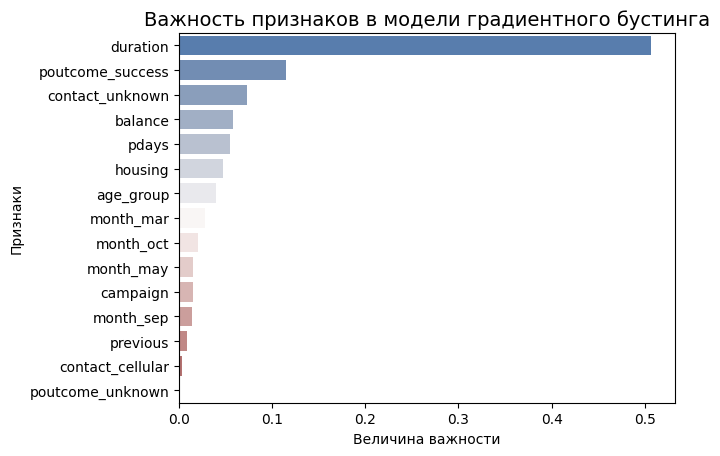

In [372]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

# Через атрибут named_estimators_ объекта StackingClassifier обратимся к модели
# градиентного бустинга по ее сокращенному названию 'gb' и далее через ее
# атрибут feature_importances_ посмотрим на распределение признаков по важности
gb_feat = pd.Series(st_cl.named_estimators_['gb'].feature_importances_,
                    index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
barplot = sns.barplot(
    data = gb_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);

barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Как видим, первая тройка признаков по важности в модели градиентного бустинга совпала с тройкой самых коррелированных признаков с целевым значением `deposit`. А вот значению баланса счета `balance` модель придала большую важность, чем количеству пропущенных дней между кампаниями `pdays` в отличии от диаграммы корреляции в задании 6 части 3 настоящего ноутбука.  

По всей видимости, длительность разговора оказывает такое большое значение на решение об открытии депозита, потому что сотрудник банка имеет возможность представить преимущества, поработать с возраениями и убедить клиента. В этой связи было бы интересно допольнительно изучить данный признак: разбить его на группы в зависимости от длительности и посмотреть на результаты, чтобы понять, какова средняя длительность успешного разговора.  

Несомненно, положительный результат в предыдущей кампании становится залогом того, что и в текущей клиент согласится с предложением банка, вероятно, проявляя лояльность и доверие.  

Что касается признака `contact_unknown`, то он столь важен потому, что, по всей видимости, означает либо личную встречу в банке, либо контакт по мобильному телефону (наиболее распространенному способу связи), который не был корректно занесен в базу данных. Примечательно, что признак, который мы хотели отбросить на этапе разведывательного анализа, оказался одним из наиболее важных!  

### Задания 6,7,8

In [75]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

# Создадим функцию расчета целевой метрики
def optuna_rf(trial,
              cv: int = 5,
              X: pd.DataFrame = X_train_scaled,
              y: pd.Series = y_train,
              random_state: int = RANDOM_SEED) -> float:
    """Функция получает объект trial, выборки и другие параметры и возвращает
    значение целевой метрики для модели случайного леса.

    Args:
        trial : объект Optuna.trial для сохранения результатов оптимизации.
        cv (int, optional): кол-во фолдов для кросс-валидации; по умолчанию = 5.
        X (pd.DataFrame, optional): обучабщая выборка; по умолчанию = X_train_scaled.
        y (pd.Series, optional): вектор ответов; по умолчанию = y_train.
        random_state (int, optional): сид воспроизводимости; по умол. = RANDOM_SEED.

    Returns:
        float: значение целевой метрики
    """       

    # Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Cоздаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = random_state
    )
    
    # Обучаем модель с помощью кросс-валидации
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # Возвращаем значение метрики
    return score

In [76]:
# Начинаем подбор гиперпараметров
# Создаем объект исследования, будем максимизировать значение метрики
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# Выполняем оптимизацию гиперпараметров 20 раз
%time study.optimize(optuna_rf, n_trials=20)

[I 2023-05-27 14:33:59,296] A new study created in memory with name: RandomForestClassifier
[I 2023-05-27 14:34:06,081] Trial 0 finished with value: 0.827100457398634 and parameters: {'n_estimators': 129, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.827100457398634.
[I 2023-05-27 14:34:11,460] Trial 1 finished with value: 0.8242560586735357 and parameters: {'n_estimators': 174, 'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.827100457398634.
[I 2023-05-27 14:34:16,525] Trial 2 finished with value: 0.8241390704691506 and parameters: {'n_estimators': 158, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.827100457398634.
[I 2023-05-27 14:34:21,891] Trial 3 finished with value: 0.8219573731405161 and parameters: {'n_estimators': 186, 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.827100457398634.
[I 2023-05-27 14:34:26,784] Trial 4 finished with value: 0.8264105505500208 and parameters: {'n_estim

CPU times: user 23.5 s, sys: 742 ms, total: 24.3 s
Wall time: 1min 38s


In [77]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров:', study.best_params)
print('f1_score на обучающем наборе:', round(study.best_value, 2))

Наилучшие значения гиперпараметров: {'n_estimators': 157, 'max_depth': 14, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.83


In [100]:
# Для тестовой выборки обучим модель с наилучшими параметрами и выведем результаты
optuna_lr = ensemble.RandomForestClassifier(**study.best_params,random_state=RANDOM_SEED)
optuna_lr.fit(X_train_scaled, y_train)
y_test_predict = optuna_lr.predict(X_test_scaled)

print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_predict), 2))
print('Метрика f1_score на тестовой выборке:',
        round(metrics.f1_score(y_test, y_test_predict), 2))

Метрика accuracy на тестовой выборке: 0.83
Метрика f1_score на тестовой выборке: 0.82


В целом, нам не удалось улучшить метрики на тестовой выборке по сравнению с заданием 1 из текущей, 5-ой части проекта (там мы тоже обучали модель случайного леса). Напомним, какие тогда были получены результаты:  
- Метрика accuracy на тестовой выборке: 0.83  
- Метрика f1_score на тестовой выборке: 0.82  

Возможно, стоит попробовать дообучить модель Optuna.

In [79]:
# Продолжим подбор гиперпараметров: добавим еще 30 итераций n_trials
%time study.optimize(optuna_rf, n_trials=30)

[I 2023-05-27 14:36:52,315] Trial 20 finished with value: 0.8235660350638371 and parameters: {'n_estimators': 119, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 17 with value: 0.8278138747042998.
[I 2023-05-27 14:36:56,702] Trial 21 finished with value: 0.8273611250192904 and parameters: {'n_estimators': 129, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 17 with value: 0.8278138747042998.
[I 2023-05-27 14:37:00,649] Trial 22 finished with value: 0.8258663013987901 and parameters: {'n_estimators': 114, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 17 with value: 0.8278138747042998.
[I 2023-05-27 14:37:05,427] Trial 23 finished with value: 0.8284287021635534 and parameters: {'n_estimators': 148, 'max_depth': 15, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.8284287021635534.
[I 2023-05-27 14:37:10,086] Trial 24 finished with value: 0.828611450564059 and parameters: {'n_estimators': 152, 'max_depth': 15, 'min_samples_leaf': 3}. Best is trial 24 with val

CPU times: user 35.9 s, sys: 1.07 s, total: 37 s
Wall time: 2min 21s


In [80]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров:', study.best_params)
print('f1_score на обучающем наборе:', round(study.best_value, 2))

Наилучшие значения гиперпараметров: {'n_estimators': 136, 'max_depth': 15, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.83


In [101]:
# Для тестовой выборки обучим модель с наилучшими параметрами и выведем результаты
optuna_lr = ensemble.RandomForestClassifier(**study.best_params,random_state=RANDOM_SEED)
optuna_lr.fit(X_train_scaled, y_train)
y_test_predict = optuna_lr.predict(X_test_scaled)

print('Метрика accuracy на тестовой выборке:',
        round(metrics.accuracy_score(y_test, y_test_predict), 2))
print('Метрика f1_score на тестовой выборке:',
        round(metrics.f1_score(y_test, y_test_predict), 2))

Метрика accuracy на тестовой выборке: 0.83
Метрика f1_score на тестовой выборке: 0.82


К сожалению, дообучение не дало искомых результатов - метрики оказались на тех же значениях.  
С помощью встроенного в Optuna графического функционала посмотрим, как шло обучение и какие параметры модели оказались наиболее важными.

In [102]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

![Optuna_Optimisation_History_Plot](img/1_Opt_Hist_Plot.png)

Целевая метрика $F_1$-score последовательно максимизируется, как можем видеть на графике.

In [83]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

![Optuna_Hyperparams_Importances](img/2_Hyper_Importances.png)

Параметр, отвечающий за минимальное количество наблюдений в каждом листе дерева `min_samples_leaf`, оказался наиболее важным среди всех, оптимизированных.  

In [94]:
optuna.visualization.plot_contour(study, params=['min_samples_leaf', 'max_depth', 'n_estimators'],
                                  target_name="f1_score")

![Optuna_Contour_Plot](img/3_Contour_Plot.png)

Наконец, на графиках контуров отношений гиперпараметров, отражающих связь между различными комбинациями гиперпараметров и значением метрики для этих комбинаций, хорошо различимы более темные зоны, соответствующие максимальным значениям метрики.  
Значения именно иъ этих интервалов мы получили как наилучшие в результате оптимизации.  

## Общий вывод по проекту  

Итак, в ходе проекта мы последовательно прошли через все этапы Data Science-задачи:  
- выполнили первичную обработку,  
- провели разведывательный анализ и выдвинули гипотезы,  
- отобрали наиболее важные признаки и подготовили из для подачи на вход модели,  
- провели классификацию с помощью различных моделей машинного обучения и построили наш прогноз.  

На каждом из этапов наши рассуждения и выводы мы подкрепили наглядными иллюстрациями.  

В итоге мы **решили бизнес-задачу по определению характеристик клиентов, более склонных к открытию депозита**: это семейные пары или неженытае/незамужние клиенты с образованием не ниже среднего, предпочтительно в возрасте до 40 или страше 60, занятые в управленческой и технической сферах, а также студенты и безработные. При этом важно их участие в предыдущих маркетинговых кампаниях банка без отрицательного негативного отношения, а еще лучше - согласие на предложение банка. Предпочтительный способ связи с ними - по мобильному телефону и, возможно, при личной встрече в банке.  

И мы также **решили стоявшую техническую задачу, предложив несколько обученных моделей МО** (случайный лес, градиентный бустинг), способных с одинаково высокой точностью предсказывать исход последующих подобных маркетинговых кампаний. Эффективность модели случайного леса мы проверили с помощью современного алгоритма оптимизации гиперпараметров Optuna.  
___